# Solution: the biggest earthquake in the UK this century

## Import modules

We first import the modules we will need to get and plot the data. We will use the `requests` module to query the USGS earthquake catalog, the `math` module to do some coordinate conversion and the `IPython` module to display a map image.

In [1]:
import requests
import math
import IPython

## Download the data

We can reuse the code provided in the exercise notebook to query the USGS earthquake catalog API using the `requests` module.

In [2]:
earthquake_catalog_api_url = "http://earthquake.usgs.gov/fdsnws/event/1/query"
query_parameters = {
    "format": "geojson",
    "starttime": "2000-01-01",
    "maxlatitude": "60.830",
    "minlatitude": "49.877",
    "maxlongitude": "1.767",
    "minlongitude": "-8.182",
    "minmagnitude": "1",
    "orderby": "time-asc"
}
quakes_response = requests.get(earthquake_catalog_api_url, params=query_parameters)

We can check that the returned object is a `Response` as expected

In [3]:
type(quakes_response)

requests.models.Response

It is also useful to check whether the status of the returned response corresponds to there not being any client or server errors, with this being indicated by a status code of 200

In [4]:
assert quakes_response.status_code == 200

## Parse the data as JSON

We saw in the exercise notebooks that the `Reponse` objects returned by `requests.get` have various attributes that allow accessing the response content in different formats including `Response.content` to get the raw `bytes` content and `Response.text` to get the response as a (Unicode) `str` object. We can print out all of the attributes of an object in Python using the inbuilt `dir` function; typically these will include attributes intended for internal use only which are conventionally indicated by prefixing with an underscore character `_`. We can display all the attributes without an initial underscore character as follows.

In [5]:
[attribute for attribute in dir(quakes_response) if attribute[0] != '_']

['apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

As well as the `content`, `ok`, `status_code` and `text` attributes we already encountered, we can see there is also a `json` attribute, which seems like it could be  relevant to our task of decoding the response as JSON. We can find out more about this attribute by using a useful feature of Jupyter / IPython - by adding a question mark `?` to the end of a Python object the documentation string (`docstring`) for that object will be displayed.

In [6]:
quakes_response.json?

Signature: quakes_response.json(**kwargs)
Docstring:
Returns the json-encoded content of a response, if any.

:param \*\*kwargs: Optional arguments that ``json.loads`` takes.
:raises simplejson.JSONDecodeError: If the response body does not
    contain valid json and simplejson is installed.
:raises json.JSONDecodeError: If the response body does not contain
    valid json and simplejson is not installed on Python 3.
:raises ValueError: If the response body does not contain valid
    json and simplejson is not installed on Python 2.        
File:      ~/miniconda3/envs/dpi/lib/python3.8/site-packages/requests/models.py
Type:      method


From this we can see that `quakes.response` is a method (function bound to an object) which returns a Python object corresponding to a JSON encoded response, which is exactly what we need. There are no required arguments so we can call the method by just adding a pair of empty parentheses.

In [7]:
quakes_json = quakes_response.json()

If we had not been aware of the `json` method an alternative would be to use the `json` module directly as we saw previously. For example the following would give an equivalent result to the above.

```Python
import json
quakes_json = json.loads(quakes_response.text)
```

## Investigate the data to discover how it is structured.

Now that we have queried and decoded the data into a Python object, we need to do some exploration to find out how it is structure. In some cases there may be documentation we can use to help guide our exploration of data - for example [this page on the USGS earthquake catalog website](https://earthquake.usgs.gov/earthquakes/feed/v1.0/geojson.php) gives a summary of the GeoJSON format. However, in other cases we may not be so lucky and have to work with data with an undocumented format so it is also useful to consider how we might explore that data structure ourselves.  


A potentially useful first step is to check what the type of the `quakes_json` object is.

In [8]:
type(quakes_json)

dict

We see that `quakes_json` is a Python `dict` (dictionary) object. We might want to find out what keys are defined in this dictionary - we can do this by calling the `keys` method.

In [9]:
quakes_json.keys()

dict_keys(['type', 'metadata', 'features', 'bbox'])

We see that the dictionary has three keys, all of which are strings. The `features` key in particular here looks potentially promising for our goal of finding the maximum magnitude event in the data (on the rationale that the magnitude is a *feature* of the event). We can check what type the value associated with the `features` key is.

In [10]:
type(quakes_json['features'])

list

We find out that the `features` key contains a list. We can check the length of this list.

In [11]:
len(quakes_json['features'])

138

We could also use a set (which we encountered previously in the lesson on dictionaries) to find out what the set of types of all of the elements in the `quakes_json['features']` list is. Similarly to the list comprehensions we encountered in a previous lesson we can use a similar syntax here to succinctly construct the set we required.

In [12]:
{type(feature) for feature in quakes_json['features']}

{dict}

From this we see that all of the elements in the `quakes_json['features']` share the same Python `dict` type. We can use a similar approach to find out what keys all these dictionary objects have.

In [13]:
{tuple(feature.keys()) for feature in quakes_json['features']}

{('type', 'properties', 'geometry', 'id')}

This tells us that as well as all the elements being dictionaries, all of the dictionaries have the same keys. This suggests the list corresponds to a representation of a sequence of objects of the same type, with each dictionary containing the 'features' for a particular object, with in in this case the objects in questions being particular earthquake events.

To check this idea, we can look at the value of a particular element in the `features` list - as we know all elements are dictionaries with the same keys, its reasonable to assume the first element `quakes_json['features'][0]` will be representative of the all the other elements in the list. We can start by summarising the keys and types of the values in this dictionary.

In [14]:
for key, value in quakes_json['features'][0].items():
    print(key, type(value).__name__)       

type str
properties dict
geometry dict
id str


We can also view the dictionary directly

In [15]:
quakes_json['features'][0]

{'type': 'Feature',
 'properties': {'mag': 2.6,
  'place': '12 km NNW of Penrith, United Kingdom',
  'time': 956553055700,
  'updated': 1415322596133,
  'tz': None,
  'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/usp0009rst',
  'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp0009rst&format=geojson',
  'felt': None,
  'cdi': None,
  'mmi': None,
  'alert': None,
  'status': 'reviewed',
  'tsunami': 0,
  'sig': 104,
  'net': 'us',
  'code': 'p0009rst',
  'ids': ',usp0009rst,',
  'sources': ',us,',
  'types': ',impact-text,origin,phase-data,',
  'nst': None,
  'dmin': None,
  'rms': None,
  'gap': None,
  'magType': 'ml',
  'type': 'earthquake',
  'title': 'M 2.6 - 12 km NNW of Penrith, United Kingdom'},
 'geometry': {'type': 'Point', 'coordinates': [-2.81, 54.77, 14]},
 'id': 'usp0009rst'}

From this we can see the `properties` and `geometry` keys both themselves map to `dict` objects. Within these inner dictionaries are several keys which look relevant to our task of identifying the highest magnitude earthquake event and displaying its location on a map. Specifically the `mag` key in the `properties` dictionary seems likely to represent the magnitude of the event 

In [16]:
quakes_json['features'][0]['properties']['mag']

2.6

while the `coordinates` key in the `geometry` dictionary seems to represent the location of the event. 

In [17]:
quakes_json['features'][0]['geometry']['coordinates']

[-2.81, 54.77, 14]

If go to the URL listed as the value for the `url` key in the `properties` dictionary, 

In [18]:
quakes_json['features'][0]['properties']['url']

'https://earthquake.usgs.gov/earthquakes/eventpage/usp0009rst'

we can confirm that this is indeed a correct interpretation of the data as the listed magnitude corresponds to the value for the `mag` key while the longitude (East-West axis) and latitude (North-South axis) coordinates (in degrees) of the event location correspond to the first two elements respectively in the list associated with the `coordinates` key (with the third coordinate corresponding to the depth of the event).

## Find the largest quake(s)

Now that we have a handle on the structure of the data, we are ready to search through the data to identify the largest magnitude earthquake event(s). We are interested in finding the element (or elements) in a sequence which maximises some property - this operation is termed the [$\arg\max$ in mathematics and computer science](https://en.wikipedia.org/wiki/Arg_max). While there is built-in `max` function in Python there is no corresponding `argmax` function, though several external libraries including the NumPy library which we encounter in a subsequent lesson do include an `argmax` function.

We will therefore loop over all of the event details in the `features` list and construct a list of the event or events for which the magnitude is currently the largest, creating a new list if the magnitude of the current event is larger than the previous largest or adding the event to the previous list if it has an equal magnitude. After iterating through all the events this list should contain the details of the event(s) with the largest magnitude. An example implementation of this approach is as follows.

In [19]:
largest_magnitude_events = [quakes_json['features'][0]]

for quake in quakes_json['features']:
    if quake['properties']['mag'] > largest_magnitude_events[0]['properties']['mag']:
        largest_magnitude_events = [quake]
    elif quake['properties']['mag'] == largest_magnitude_events[0]['properties']['mag']:
        largest_magnitude_events += [quake]

We can now check if there was a single event with the maximum magnitude or multiple

In [20]:
len(largest_magnitude_events)

2

It turns out there are two events with the same maximal magnitude. As a sanity check we can print the magnitude of both events to check that they match

In [21]:
print([quake['properties']['mag'] for quake in largest_magnitude_events])

[4.8, 4.8]


## Get a map at the point of the quakes

There are various different web services which can be used to get map imagery, here we will [OpenStreetMap](https://www.openstreetmap.org/). Specifically we will get a pre-rendered map tile containing a location specified by latitude and longitude coordinates as a *portable network graphic* (PNG) image. [This page](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python) on the OpenStreeMap wiki gives a Python implementation of a function `deg2num` to convert from a latitude-longitude pair in degrees plus a [zoom level](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Zoom_levels), to a pair of indices specifying a specific map tile. 

In [22]:
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

There are various [tile servers](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Tile_servers) for the OpenStreetMap data with differing rendering styles and URL templates. Here we use the 'standard' style tiles for which an appropiate URL template is `http://a.tile.openstreetmap.org/{zoom}/{x}/{y}.png` where `{zoom}` indicates the zoom level and `{x}` and `{y}` the two components of tile number returned by `deg2num`. We can use Python [formatted string literals](https://docs.python.org/3/tutorial/inputoutput.html#tut-f-strings) to populate the template with the appropriate values and use the `requests.get` function to request the image corresponding to the URL. Finally we can create an [`IPython.display.Image` object](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.Image) which will display the raw data corresponding to the contents of the image request as an image in the Jupyter Lab front end. We wrap this all in to a function `get_map_tile_at` to allow us to use it to display images for each of the largest magnitude earthquake events identified earlier.

In [23]:
def get_map_tile_at(latitude, longitude, zoom=10, satellite=False): 
    x, y = deg2num(latitude, longitude, zoom)
    tile_url = f"http://a.tile.openstreetmap.org/{zoom}/{x}/{y}.png"
    response = requests.get(tile_url)
    assert response.status_code == 200
    return IPython.core.display.Image(response.content)

As a test we can check the map displayed for the coordinates of the [Prime meridian at the Royal Observatory Greenwich](https://geohack.toolforge.org/geohack.php?pagename=Prime_meridian_(Greenwich)&params=51_28_40.1_N_0_0_5.3_W_type:landmark_globe:earth_region:GB_scale:1000)

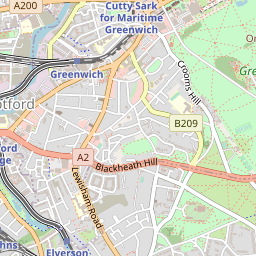

In [24]:
get_map_tile_at(latitude=51.477806, longitude=-0.001472, zoom=14) 

## Display the maps

We can now finally show the maps for the locations of the maximum magnitude earthquake events. As additional check we also print the description under the `title` key in the `properties` dictionary for the event to check it tallies with the location shown in the displayed map.

M 4.8 - 2 km ESE of Wombourn, United Kingdom


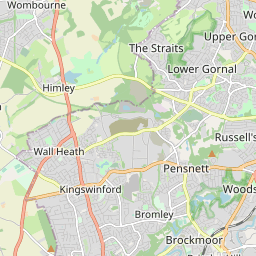

M 4.8 - 1 km NNE of Market Rasen, United Kingdom


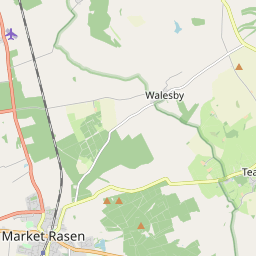

In [25]:
for quake in largest_magnitude_events:
    longitude = quake['geometry']['coordinates'][0]
    latitude = quake['geometry']['coordinates'][1]
    print(quake['properties']['title'])
    display(get_map_tile_at(latitude, longitude, 12))